In [2]:
import os
import sys


IS_COLAB = True
HOME = "/content"

In [4]:
%cd {HOME}
!{sys.executable} -m pip install "git+https://github.com/facebookresearch/segment-anything.git"

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1fzwqzqu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1fzwqzqu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit c1910835a32a05cbb79bdacbec8f25914a7e3a20
  Preparing metadata (setup.py) ... done


In [5]:
!pip install -q  opencv-python pycocotools matplotlib onnxruntime onnx jupyter_bbox_widget roboflow dataclasses-json supervision 

In [6]:
import cv2
import torch
import numpy as np
import supervision as sv

### SAM weights
Model is available with different backbone sizes, here, default ("vit_h") model will be used.  

Checkpoints for the other two model types:
- `vit_l`: [ViT-L SAM model.](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth)
- `vit_b`: [ViT-B SAM model.](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth)

In [7]:
%cd {HOME}
!mkdir {HOME}/weights

%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


In [8]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [33]:
%cd {HOME}
!mkdir {HOME}/imgs
%cd {HOME}/imgs

!wget -c https://www.blog.urbact.eu/wp-content/uploads/parking-policy-2.jpg -O image0.jpg
!wget -c https://www.chipsaway.co.uk/wp-content/uploads/2021/09/iStock-1183728613-700x467.jpg -O image1.jpg
!wget -c https://d13esfgglb25od.cloudfront.net/lot_img/196450/ed2e3a16af274b2c82bf1a26fc3686ff.jpg -O image2.jpg
!wget -c https://balkangreenenergynews.com/wp-content/uploads/2023/03/EU-deal-ban-sales-new-diesel-gasoline-cars-2035.jpg -O image3.jpg
!wget -c https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/complete-bmw-buying-guide-lead-1664897488.jpg -O image4.jpg
!wget -c https://www.dsf.my/wp-content/uploads/2022/04/BMW-i4-vs-iX-in-Malaysia-1.png?v=1650076647 -O image5.jpg
!wget -c https://i2-prod.chroniclelive.co.uk/incoming/article24721349.ece/ALTERNATES/s1200/1_JS245532052.jpg -O image6.jpg

/content
mkdir: cannot create directory ‘/content/imgs’: File exists
/content/imgs
--2023-04-12 20:23:02--  https://www.blog.urbact.eu/wp-content/uploads/parking-policy-2.jpg
Resolving www.blog.urbact.eu (www.blog.urbact.eu)... 87.252.12.39
Connecting to www.blog.urbact.eu (www.blog.urbact.eu)|87.252.12.39|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2023-04-12 20:23:03--  https://www.chipsaway.co.uk/wp-content/uploads/2021/09/iStock-1183728613-700x467.jpg
Resolving www.chipsaway.co.uk (www.chipsaway.co.uk)... 185.181.197.228, 2a02:21a8:0:3::8121:af16
Connecting to www.chipsaway.co.uk (www.chipsaway.co.uk)|185.181.197.228|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-04-12 20:23:04 ERROR 404: Not Found.

--2023-04-12 20:23:04--  https://d13esfgglb25od.cloudfront.net/lot_img/196450/ed2e3a16af274b2c82bf1a26fc3686ff.jpg
Resolving d13esfgglb25od.clou

### Load model

In [10]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"

In [11]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

### Automated mask generation


In [12]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [34]:
img_name = "image6.jpg"
IMG_PATH = os.path.join(HOME, "imgs", img_name)

In [35]:
img_bgr = cv2.imread(IMG_PATH)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(img_rgb)

print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Segmentation results

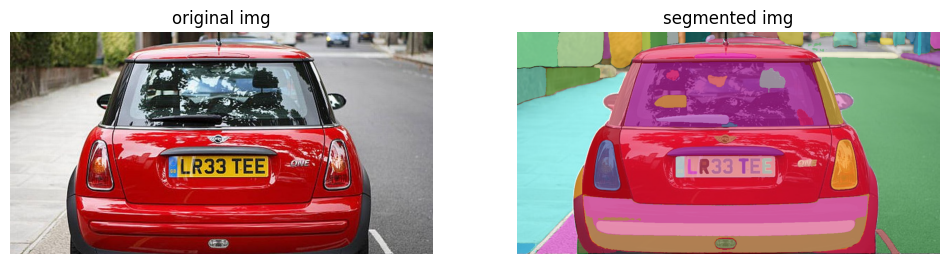

In [36]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_img = mask_annotator.annotate(scene=img_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[img_bgr, annotated_img],
    grid_size=(1,2),
    titles=["original img", "segmented img"]
)

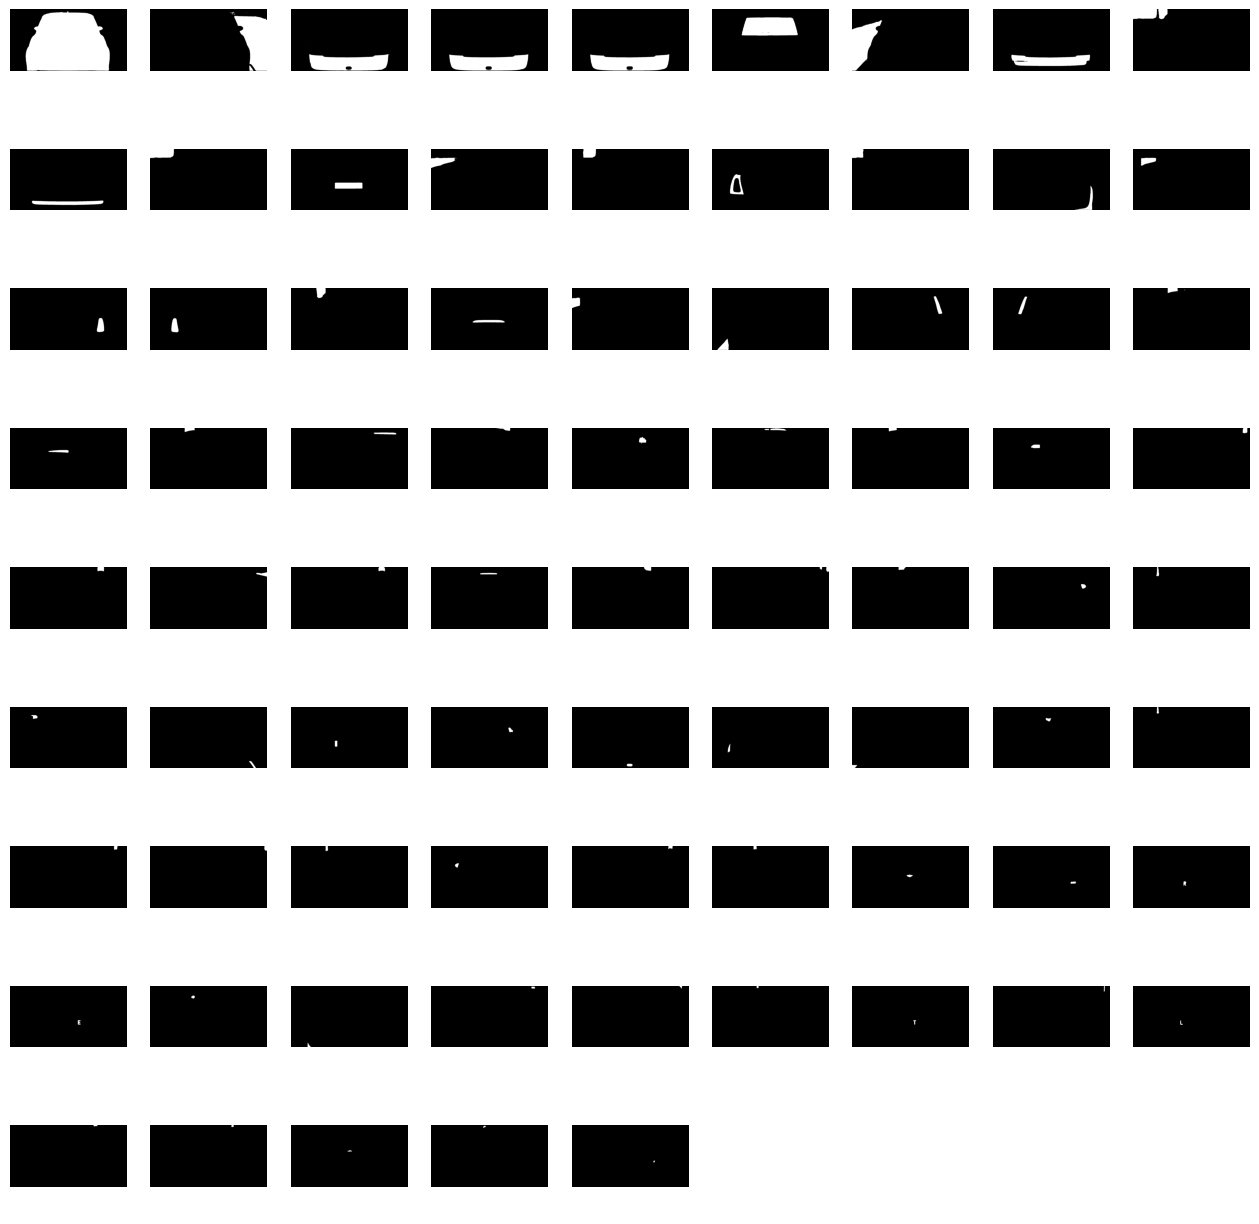

In [37]:
masks = [
    mask['segmentation']
    for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks, 
    grid_size=(9, int(len(masks) / 8)),
    size=(16,16)
)

### Segmentation with bounding boxes


In [38]:
mask_predictor = SamPredictor(sam)

In [39]:
import base64

def encode_image(filepath):
  with open(filepath, 'rb') as f:
    img_bytes = f.read()
  encoded = str(base64.b64encode(img_bytes), 'utf-8')
  return "data:image/jpg;base64,"+encoded

In [40]:
if IS_COLAB:
  from google.colab import output
  output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMG_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [41]:
widget.bboxes

[{'x': 414, 'y': 288, 'width': 360, 'height': 162, 'label': ''},
 {'x': 796, 'y': 507, 'width': 0, 'height': 0, 'label': ''}]

### Masks generation

In [42]:
default_box = widget.bboxes[0]

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']
])

In [43]:
image_bgr = cv2.imread(IMG_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Visualisation

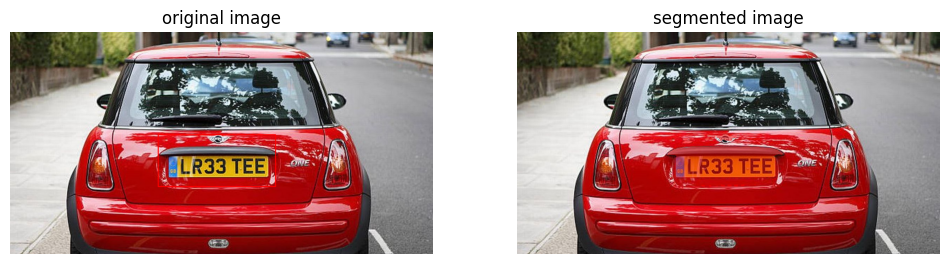

In [44]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

original_img = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_img = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[original_img, segmented_img],
    grid_size=(1, 2),
    titles=['original image', 'segmented image']
)

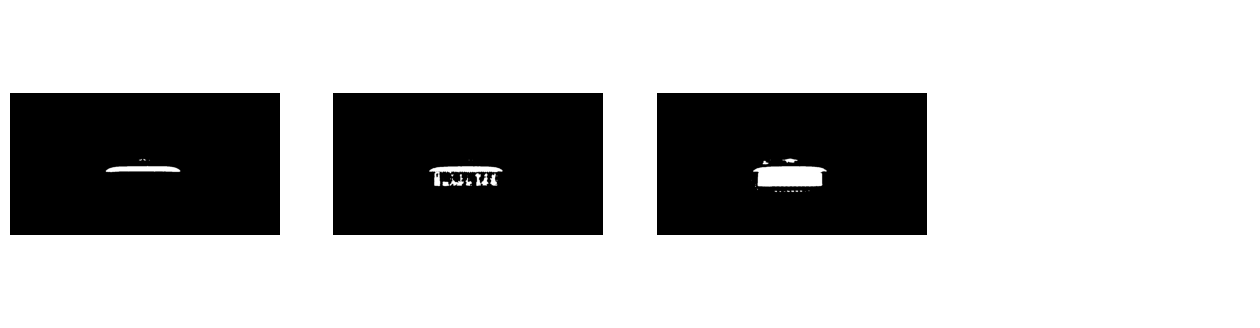

In [45]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)